In [ ]:
!pip install POT==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 13.6 MB/s eta 0:00:00


In [ ]:

import PIL
import ot
import numpy as np


def coupling_matrix_projection(P, hist):

    def projection(x, exp_sum):
      """Projection of a vector x on the set of postive vectors whose coefficient sum to exp_sum"""
      n = len(x)
      sorted_x = np.sort(x)[::-1]  # sort in descending order

      cumsum = np.cumsum(sorted_x)
      # compute the projection onto the diagonal matrix
      proj = (cumsum - exp_sum) / np.arange(1, n+1)

      i = np.argmax(proj >= sorted_x) - 1

      proj = proj[i] if i >= 0 else (np.sum(x) - exp_sum) / n

      # return projection
      return np.maximum(x - proj, 0)

    projection_v = np.vectorize(projection, signature='(n),()->(n)')
    proj = projection_v(P, hist)
    return proj



def compute_objective(source, target, cost_matrix, coupling_matrix, rho, mu, alpha):
    """
    Compute the objective function for OTDA.
    """
    source_color_features = source.features[:, 2:]
    target_color_features = target.features[:, 2:]
    num_source_samples = source_color_features.shape[0]
    num_target_samples = target_color_features.shape[0]
    feature_dim = 3  # features' dimension (here 3 color channels)

    transport_map = source.Dh @ coupling_matrix @ target_color_features  # transport map
    transport_flow = transport_map - source_color_features  # transport flow

    fidelity_term = 0.5 * np.linalg.norm(np.dot(np.ones(num_source_samples), coupling_matrix @ np.sqrt(target.Dh))) ** 2 - 0.5
    regularity_term = 0.5 * np.linalg.norm(np.dot(source.Dh_inv, np.reshape(source.G @ transport_flow, (num_source_samples, num_source_samples, feature_dim)))) ** 2
    dispersion_term = np.sum(coupling_matrix * (np.ones(num_target_samples) @ np.diag(target_color_features @ target_color_features.T).T - source.Dh_inv @ coupling_matrix @ target_color_features @ target_color_features.T))

    return np.sum(cost_matrix * coupling_matrix) + rho * fidelity_term + mu * regularity_term + alpha * dispersion_term


def compute_objective_grad(u, v, C, P, rho, mu, alpha):
    X, Y = u.features[:, 2:], v.features[:, 2:]  # color features
    n, m = X.shape[0], Y.shape[0]

    T = u.Dh @ P @ Y  # transport map
    V = T - X  # transport flow

    grad_F = np.ones((n, n)) @ P @ v.Dh  # fidelity term

    # regularization term
    scaling = np.repeat(u.hist ** 2, n)[:, np.newaxis]  # scaling for the pseudo laplacian
    grad_R = u.Dh @ (u.G.T @ (scaling * (u.G @ V))) @ Y.T

    grad_D = np.ones(m) @ np.diag(Y @ Y.T).T - 2 * u.Dh_inv @ P @ Y @ Y.T  # dispersion term

    return C + rho * grad_F + mu * grad_R + alpha * grad_D


def compute_transport_map(u, v, num_iter, tau, rho, mu, alpha, beta, num_neighbors):

    X, Y = u.features[:, 2:], v.features[:, 2:]  # color features
    n, m = X.shape[0], Y.shape[0]
    u.build_graph(num_neighbors)

    C = np.array([[np.linalg.norm(X[i] - Y[j]) ** 2 for j in range(m)] for i in range(n)])  # cost matrix

    P = ot.emd(u.hist, v.hist, C)  # initialization as the optimal transport matrix
    assert(np.allclose(coupling_matrix_projection(P, u.hist), P))  # assert the projection behaves normally

    objective = compute_objective(u, v, C, P, rho, mu, alpha)

    former_P = P
    former_objective = objective

    for _ in range(num_iter):
        previous_update = P - former_P
        former_P = P
        former_objective = objective

        objective_grad = compute_objective_grad(u, v, C, P, rho, mu, alpha)

        P = P - tau * objective_grad + beta * previous_update
        P = coupling_matrix_projection(P, u.hist)

        objective = compute_objective(u, v, C, P, rho, mu, alpha)

        if np.abs(objective - former_objective) / former_objective < 1e-5:
            break

    transport_map = u.Dh @ P @ Y

    return transport_map


def post_processing(u, transport_map, sigma):
    """
    allows to recover geometrical information from the source image
    """

    w = np.zeros_like(u.array)  # synthesis result

    for i in range(u.array.shape[0]):
        for j in range(u.array.shape[1]):

            point_feature = np.hstack([np.array([i / u.array.shape[0], j / u.array.shape[1]]), u.array[i, j]])

            # similarity of pixel (i, j) in the source image with each cluster
            clusters_weight = np.exp(- 0.5 * np.linalg.norm(u.features - point_feature[np.newaxis, :], axis=1)
                                     / sigma ** 2)

            w[i, j] = np.sum(clusters_weight[:, np.newaxis] * transport_map, axis=0) / np.sum(clusters_weight)

    return w


def color_transfer(u, v, num_iter, tau, rho, mu, alpha, beta, num_neighbors, num_segments, sigma):

    u.quantize(num_segments)
    v.quantize(num_segments)

    transport_map = compute_transport_map(u, v, num_iter, tau, rho, mu, alpha, beta, num_neighbors)

    return post_processing(u, transport_map, sigma)



In [ ]:
import PIL
import numpy as np

from skimage.segmentation import slic  # super pixels
from scipy.sparse import csr_matrix  # sparse matrices for graph weights


class Image:
    """
    Class to handle quantization of images
    """

    def __init__(self, path):
        pil_image = PIL.Image.open(path)
        self.array = np.array(pil_image, dtype='float') / 255

        self.segments = None
        self.clusters = None
        self.hist = None
        self.features = None
        self.quantized_array = None

        self.is_quantized = False

        self.weights = None
        self.G = None

    def _compute_clusters(self, num_segments):
        segments = slic(self.array, n_segments=num_segments, sigma=5)
        clusters = [{} for _ in range(np.unique(segments).size + 1)]

        for i in range(segments.shape[0]):
            for j in range(segments.shape[1]):
                cluster_idx = segments[i, j]

                if clusters[cluster_idx] == {}:
                    clusters[cluster_idx]['spatial_mean'] = np.array([i / self.array.shape[0],
                                                                      j / self.array.shape[1]])
                    clusters[cluster_idx]['color_mean'] = self.array[i, j]
                    clusters[cluster_idx]['num_pixels'] = 1
                else:
                    clusters[cluster_idx]['spatial_mean'] += np.array([i / self.array.shape[0],
                                                                       j / self.array.shape[1]])
                    clusters[cluster_idx]['color_mean'] += self.array[i, j]
                    clusters[cluster_idx]['num_pixels'] += 1

        for cluster in clusters:
          if cluster:
            cluster['spatial_mean'] /= cluster['num_pixels']
            cluster['color_mean'] /= cluster['num_pixels']

        self.segments = segments
        self.clusters = clusters

    def _compute_histogram(self):
        """
        compute the feature vector and the weight of each cluster
        """

        num_pixels = self.array.shape[0] * self.array.shape[1]
        hist = []
        features = []

        for cluster in self.clusters:
          if cluster != {}:
            hist.append(cluster['num_pixels'] / num_pixels)
            features.append(np.hstack([cluster['spatial_mean'], cluster['color_mean']]))

        self.hist = np.array(hist)
        self.features = np.array(features)

        # matrices used to compute the transport problem's objective
        self.Dh = np.diag(1 / self.hist)
        self.Dh_inv = np.diag(self.hist)

        assert(np.sum(self.hist) == 1)

    def _compute_quantized_image(self):
        """
        assign to all pixels of a given cluster its mean color (only useful for visualization)
        """

        quantized_array = np.zeros_like(self.array)

        for i in range(self.array.shape[0]):
            for j in range(self.array.shape[1]):
                quantized_array[i, j] = self.clusters[self.segments[i, j]]['color_mean']

        self.quantized_array = quantized_array

    def quantize(self, num_segments):
        self._compute_clusters(num_segments)
        self._compute_histogram()
        self._compute_quantized_image()

        self.is_quantized = True

    def build_graph(self, num_neighbors):
        """
        build a graph whose vertices are clusters and edges have a weight proportional to their features' similarity
        this graph is used through the gradient it defines to regularize the transport map
        """

        num_features = self.features.shape[0]

        # weights[i, j] measures the similarity between cluster i and j
        weights = np.array([[0 if i == j else 1 / np.linalg.norm(self.features[i] - self.features[j])
                             for j in range(num_features)]
                            for i in range(num_features)])

        graph_grad = np.zeros((num_features, num_features, num_features))

        for i in range(num_features):
            ranked_neighbors = np.argsort(weights[i])[::-1]  # only keeps

            for j in range(num_neighbors):  # only keep top neighbors for computational efficiency
                graph_grad[i, ranked_neighbors[j], i] = weights[i, ranked_neighbors[j]]
                graph_grad[i, ranked_neighbors[j], ranked_neighbors[j]] = - weights[i, ranked_neighbors[j]]

        graph_grad = np.reshape(graph_grad, (num_features ** 2, num_features))
        self.G = csr_matrix(graph_grad)

In [ ]:
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from skimage.segmentation import mark_boundaries

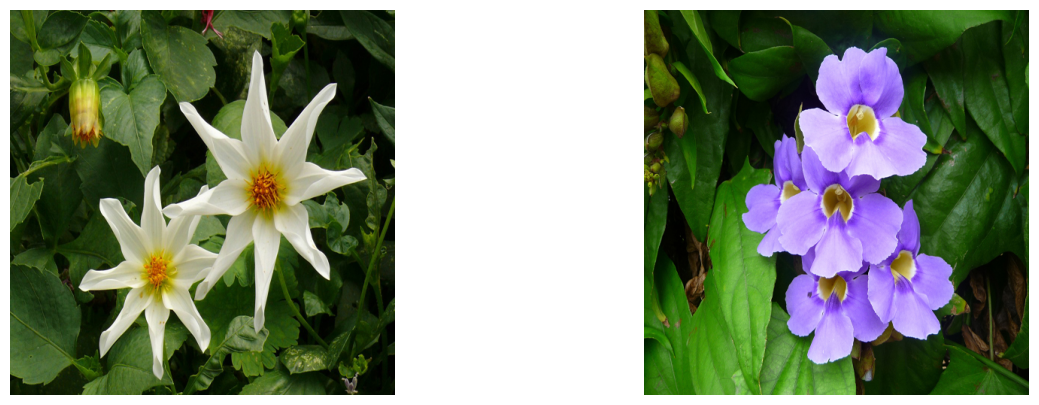

In [ ]:
u = Image('flower_1.jpg')
v = Image('flower_2.jpg')

# image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(u.array)
ax1.axis('off')

ax2.imshow(v.array)
ax2.axis('off');

In [ ]:
num_segments = 300

In [ ]:
# hyper-parameters
num_iter = 1000
tau = 1e-4
rho = 2e-1
mu = 5e-1
alpha = 3e-3
beta = 0.0
num_neighbors = 50
sigma = 0.2

In [ ]:
im = color_transfer(u, v, num_iter, tau, rho, mu, alpha, beta, num_neighbors, num_segments, sigma)

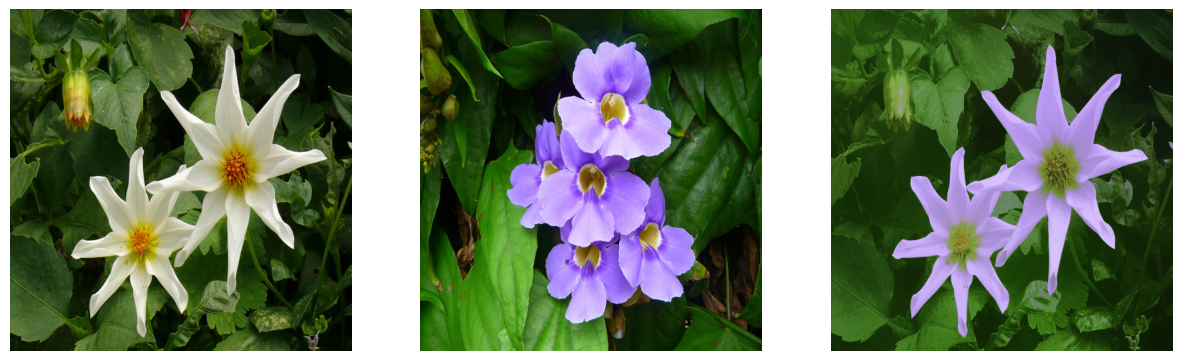

In [ ]:
# color transfer result (original scale)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(u.array)
ax1.axis('off')

ax2.imshow(v.array)
ax2.axis('off')

ax3.imshow(im)
ax3.axis('off');

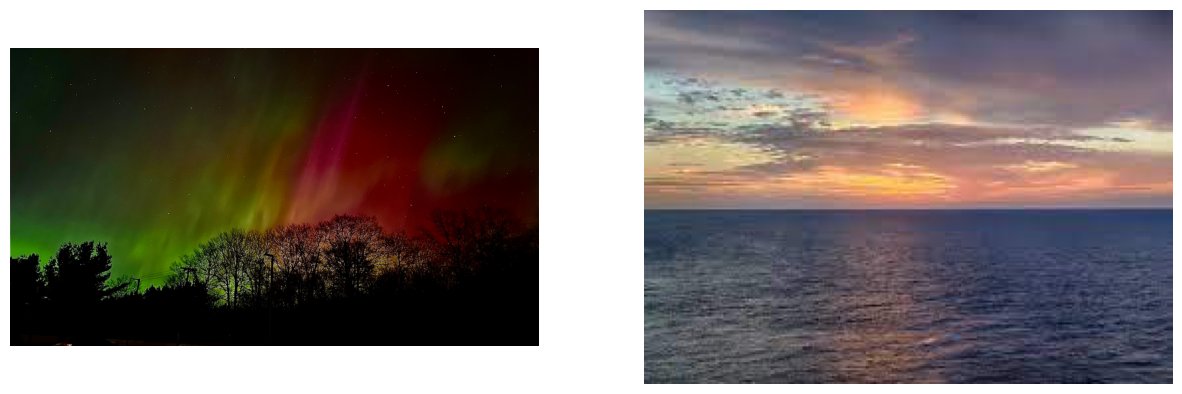

In [ ]:
a = Image('nothern_lights.jpg')

b = Image('ocean.jpg')

# image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(a.array)
ax1.axis('off')

ax2.imshow(b.array)
ax2.axis('off');

In [ ]:
im = color_transfer(a, b, num_iter, tau, rho, mu, alpha, beta, num_neighbors, num_segments, sigma)

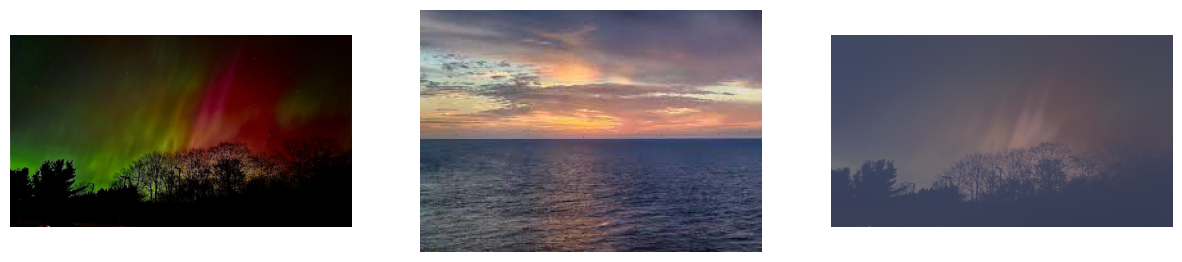

In [ ]:
# color transfer result (original scale)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(a.array)
ax1.axis('off')

ax2.imshow(b.array)
ax2.axis('off')

ax3.imshow(im)
ax3.axis('off');

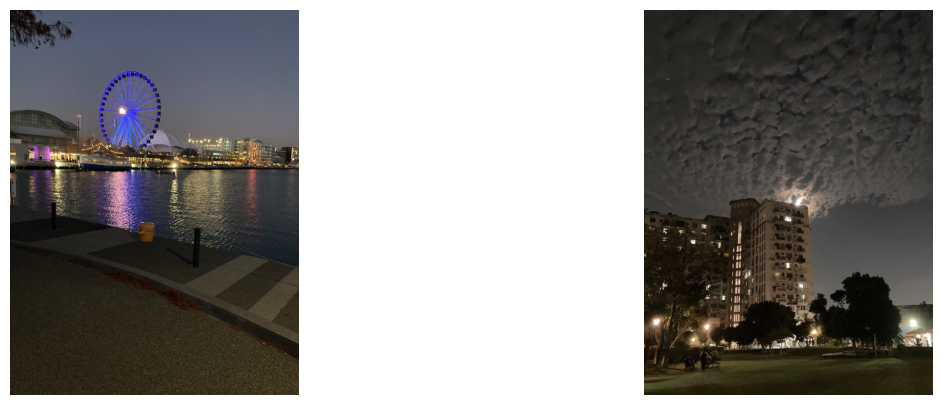

In [ ]:
c = Image('chicago_ferris.png')

d = Image('night_sky.png')

# image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(c.array)
ax1.axis('off')

ax2.imshow(d.array)
ax2.axis('off');

In [ ]:
im = color_transfer(c, d, num_iter, tau, rho, mu, alpha, beta, num_neighbors, num_segments, sigma)

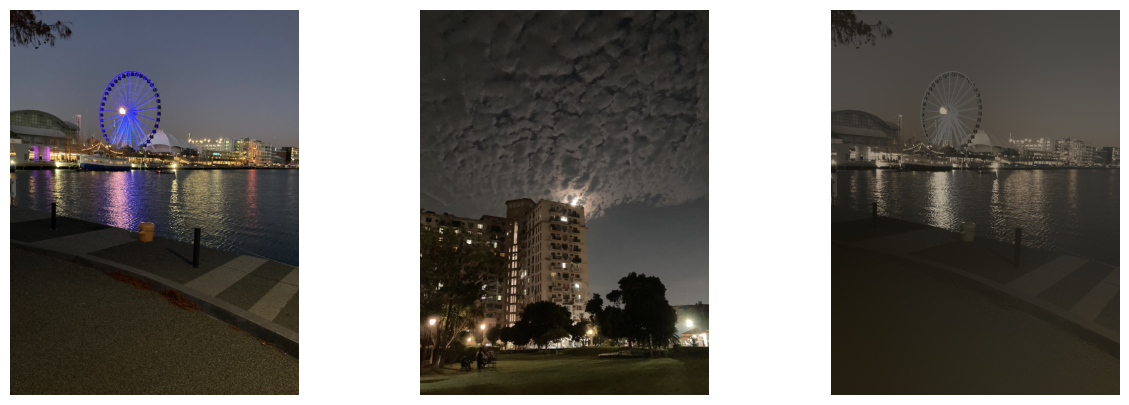

In [ ]:
# color transfer result (original scale)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(c.array)
ax1.axis('off')

ax2.imshow(d.array)
ax2.axis('off')

ax3.imshow(im)
ax3.axis('off');